# ИМПОРТИРУЕМ НЕОБХОДИМЫЕ БИБЛИОТЕКИ

In [2]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/dannie'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import SVD, SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import cross_validate
import difflib
import random

# Считываем нужные нам данные

In [6]:
fail_user = "/kaggle/input/restoran/rating_final.csv"
file_geo = "/kaggle/input/restoran/geoplaces2.csv"
data = pd.read_csv(fail_user)
data_geo = pd.read_csv(file_geo)

# Есть ли пропущенные значения в данных

In [9]:
data_geo.isnull().sum()

placeID           0
latitude          0
longitude         0
the_geom_meter    0
name              0
address           0
city              0
state             0
country           0
fax               0
zip               0
alcohol           0
smoking_area      0
dress_code        0
accessibility     0
price             0
url               0
Rambience         0
franchise         0
area              0
other_services    0
dtype: int64

In [10]:
data.isnull().sum()

userID            0
placeID           0
name              0
rating            0
food_rating       0
service_rating    0
dtype: int64

# Объединяем 2 таблицы

In [12]:
data = pd.merge(data, data_geo[['placeID', 'name']], on='placeID')
data = data[['userID', 'placeID' ,'name', 'rating', 'food_rating', 'service_rating']]
data.head()

,userID,placeID,name,rating,food_rating,service_rating
0,U1077,135085,Tortas Locas Hipocampo,2,2,2
1,U1108,135085,Tortas Locas Hipocampo,1,2,1
2,U1081,135085,Tortas Locas Hipocampo,1,2,1
3,U1056,135085,Tortas Locas Hipocampo,2,2,2
4,U1134,135085,Tortas Locas Hipocampo,2,1,2


# Этап 1

# Топ-10 самых посещаемых ресторанов

In [13]:
placeID_group = data.groupby('placeID')
placeID_grouped_data = placeID_group.count().sort_values(by='rating', ascending=False)
placeID_grouped_data.iloc[ : 10]

,userID,name,rating,food_rating,service_rating
placeID,,,,,
135085,36,36,36,36,36
132825,32,32,32,32,32
135032,28,28,28,28,28
135052,25,25,25,25,25
132834,25,25,25,25,25
135038,24,24,24,24,24
135060,22,22,22,22,22
135062,21,21,21,21,21
135042,20,20,20,20,20


# 10 лучших ресторанов с самым высоким средним рейтингом food_rating.

In [14]:
placeID_food_rating_data = data.groupby('placeID').mean().sort_values(by='food_rating', ascending=False)
placeID_food_rating_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
132667,1.250000,2.000000,1.250000
134986,2.000000,2.000000,2.000000
135034,2.000000,2.000000,1.600000
132755,1.800000,2.000000,1.600000
135013,1.750000,2.000000,1.750000
132955,2.000000,1.800000,1.800000
134976,1.750000,1.750000,1.000000
135074,1.750000,1.750000,1.750000
135018,1.500000,1.750000,1.500000


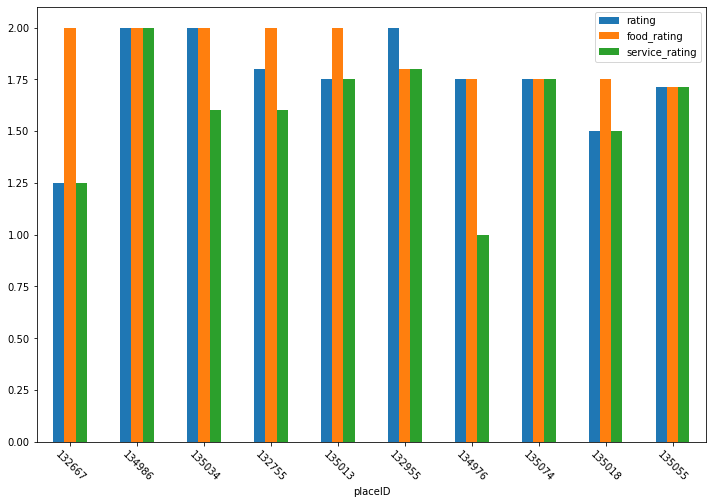

In [15]:
placeID_food_rating_data.iloc[ : 10].plot(kind='bar', figsize=(12,8))
plt.xticks(rotation=-45)
plt.show()

In [16]:
print("Ресторан {} имеет средний рейтинг food_rating 2, что является максимальным, но у него низкие общие рейтинги и service_ratings.".format(data[data['placeID'] == 132667]['name'].iloc[0] ))

Ресторан little pizza Emilio Portes Gil имеет средний рейтинг food_rating 2, что является максимальным, но у него низкие общие рейтинги и service_ratings.


# Топ-10 ресторанов с самыми высокими средними общими рейтингами.

In [17]:
# группируем данные по placeID

placeID_group = data.groupby('placeID')
placeID_grouped_data = placeID_group.count().sort_values(by='rating', ascending=False)
placeID_grouped_data.iloc[ : 10]

,userID,name,rating,food_rating,service_rating
placeID,,,,,
135085,36,36,36,36,36
132825,32,32,32,32,32
135032,28,28,28,28,28
135052,25,25,25,25,25
132834,25,25,25,25,25
135038,24,24,24,24,24
135060,22,22,22,22,22
135062,21,21,21,21,21
135042,20,20,20,20,20


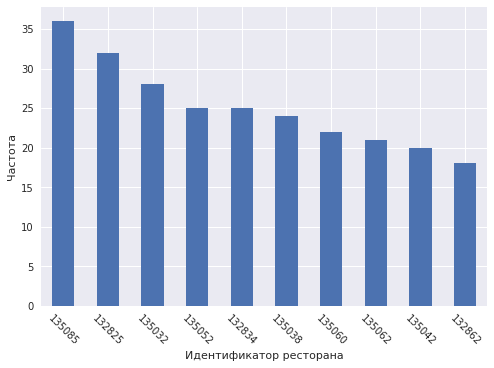

In [18]:
plt.style.use('seaborn')
placeID_grouped_data.iloc[ : 10]['rating'].plot(kind='bar')
plt.xlabel("Идентификатор ресторана")
plt.ylabel("Частота")
plt.xticks(rotation=-45)
plt.show()

# Топ-10 ресторанов с самыми высокими средними общими рейтингами.

In [19]:
placeID_ratings_data = data.groupby('placeID').mean().sort_values(by='rating', ascending=False)
placeID_ratings_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
132955,2.000000,1.800000,1.800000
135034,2.000000,2.000000,1.600000
134986,2.000000,2.000000,2.000000
132922,1.833333,1.500000,1.833333
132755,1.800000,2.000000,1.600000
135013,1.750000,2.000000,1.750000
134976,1.750000,1.750000,1.000000
135074,1.750000,1.750000,1.750000
135055,1.714286,1.714286,1.714286


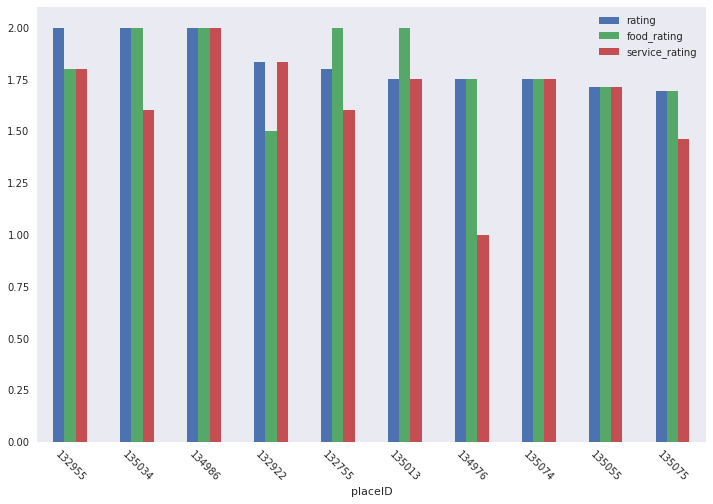

In [20]:
plt.style.use('seaborn')
placeID_ratings_data.iloc[ : 10].plot(kind='bar', figsize=(12,8))
plt.xticks(rotation=-45)
plt.grid()
plt.show()

In [21]:
print("Ресторан с самым высоким средним общим рейтингом, food_rating и service_rating: {}".format(data[data['placeID'] == 134986]['name'].iloc[0]))

Ресторан с самым высоким средним общим рейтингом, food_rating и service_rating: Restaurant Las Mananitas


# 10 ресторанов с самым высоким средним рейтингом food_rating.

In [22]:
placeID_food_rating_data = data.groupby('placeID').mean().sort_values(by='food_rating', ascending=False)
placeID_food_rating_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
132667,1.250000,2.000000,1.250000
134986,2.000000,2.000000,2.000000
135034,2.000000,2.000000,1.600000
132755,1.800000,2.000000,1.600000
135013,1.750000,2.000000,1.750000
132955,2.000000,1.800000,1.800000
134976,1.750000,1.750000,1.000000
135074,1.750000,1.750000,1.750000
135018,1.500000,1.750000,1.500000


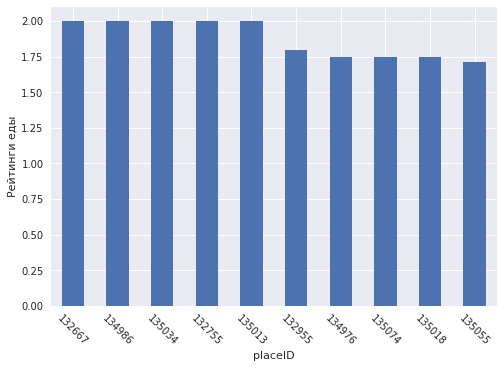

In [23]:
plt.style.use('seaborn')
placeID_food_rating_data['food_rating'].iloc[ : 10].plot(kind='bar')
plt.ylabel("Рейтинги еды")
plt.xticks(rotation=-45)
plt.show()

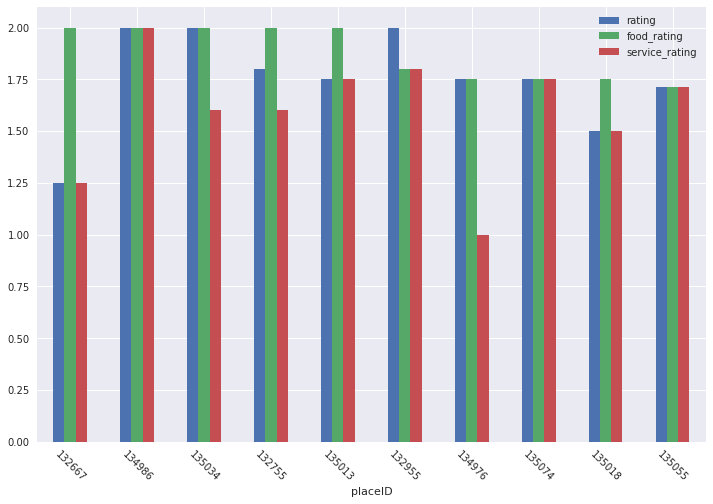

In [24]:
placeID_food_rating_data.iloc[ : 10].plot(kind='bar', figsize=(12,8))
plt.xticks(rotation=-45)
plt.show()

# Топ-10 наименее посещаемых ресторанов (наименее встречающихся в данных).

In [25]:
placeID_rating_data = data.groupby('placeID').count().sort_values(by='rating')

In [26]:
placeID_rating_data.iloc[ : 10]

,userID,name,rating,food_rating,service_rating
placeID,,,,,
135011,3,3,3,3,3
132668,3,3,3,3,3
134975,3,3,3,3,3
132766,3,3,3,3,3
135016,3,3,3,3,3
132717,3,3,3,3,3
135033,4,4,4,4,4
135018,4,4,4,4,4
135040,4,4,4,4,4


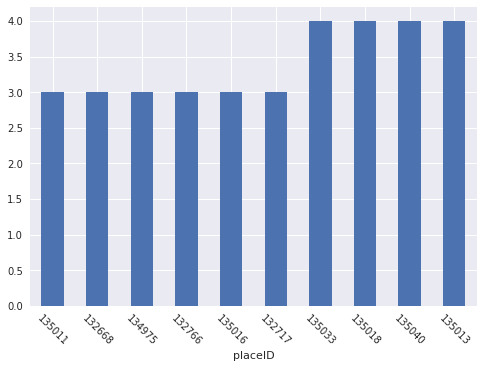

In [27]:
placeID_rating_data['rating'].iloc[ : 10].plot(kind='bar')
plt.xticks(rotation=-45)
plt.show()

# 10 ресторанов с самым низким средним общим рейтингом.

In [28]:
placeID_ratings_data = data.groupby('placeID').mean().sort_values(by='rating', ascending=True)
placeID_ratings_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
132654,0.250,0.250,0.250000
135040,0.250,0.250,0.250000
132560,0.500,1.000,0.250000
132663,0.500,0.500,0.666667
135069,0.500,0.500,0.750000
132594,0.600,1.200,0.600000
132609,0.600,0.600,0.600000
132885,0.600,0.600,0.400000
132870,0.600,1.000,0.400000


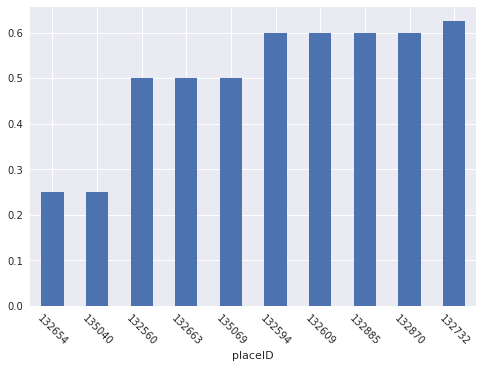

In [29]:
# Нарисуем приведенные выше данные

placeID_ratings_data['rating'].iloc[ : 10].plot(kind='bar')
plt.xticks(rotation=-45)
plt.show()

# 10 ресторанов с самым низким средним рейтингом food_rating

In [30]:
placeID_service_rating_data = data.groupby('placeID').mean().sort_values(by='food_rating', ascending=True)
placeID_service_rating_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
135040,0.25,0.25,0.250000
132654,0.25,0.25,0.250000
134987,1.00,0.50,1.000000
132663,0.50,0.50,0.666667
135069,0.50,0.50,0.750000
135086,0.80,0.60,0.800000
132845,0.80,0.60,0.800000
132609,0.60,0.60,0.600000
135049,1.00,0.60,1.000000


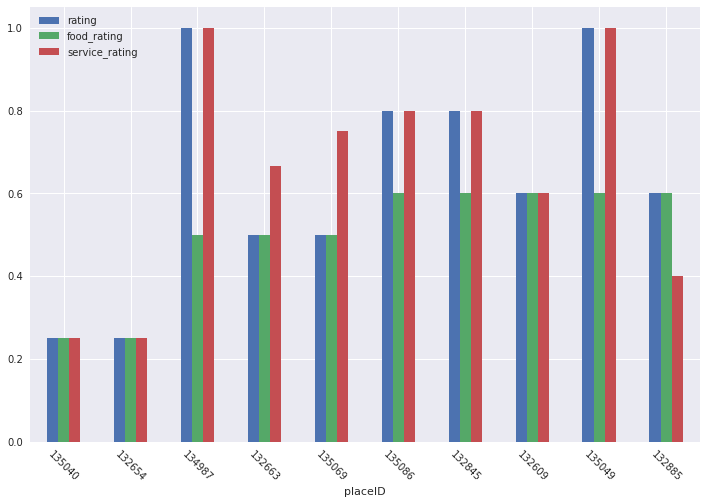

In [31]:
placeID_service_rating_data.iloc[ : 10].plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=-45)
plt.show()

# 10 ресторанов с самым низким средним рейтингом service_rating.

In [32]:
placeID_service_rating_data = data.groupby('placeID').mean().sort_values(by='service_rating', ascending=True)
placeID_service_rating_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
132560,0.50,1.00,0.250
132654,0.25,0.25,0.250
135040,0.25,0.25,0.250
132870,0.60,1.00,0.400
132885,0.60,0.60,0.400
132715,1.00,1.00,0.500
132594,0.60,1.20,0.600
132609,0.60,0.60,0.600
132858,0.80,1.40,0.600


# Топ-10 ресторанов с самым низким средним рейтингом food_rating, service_rating

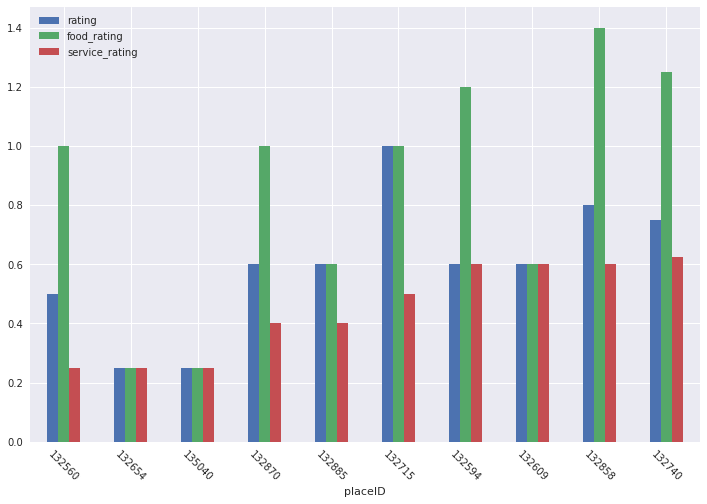

In [33]:
placeID_service_rating_data.iloc[ : 10].plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=-45)
plt.show()

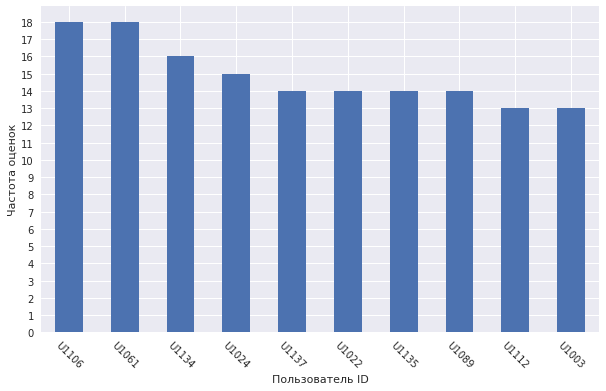

In [34]:
data.groupby('userID').count().sort_values(by='rating', ascending=False).iloc[ : 10]['rating'].plot(kind='bar', figsize=(10,6))
plt.xlabel("Пользователь ID")
plt.ylabel("Частота оценок")
plt.xticks(rotation=-45)
plt.yticks(np.arange(0,19,1))
plt.show()

In [35]:
data[['rating', 'food_rating', 'service_rating']].describe()

,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000
mean,1.199828,1.215332,1.090439
std,0.773282,0.792294,0.790844
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


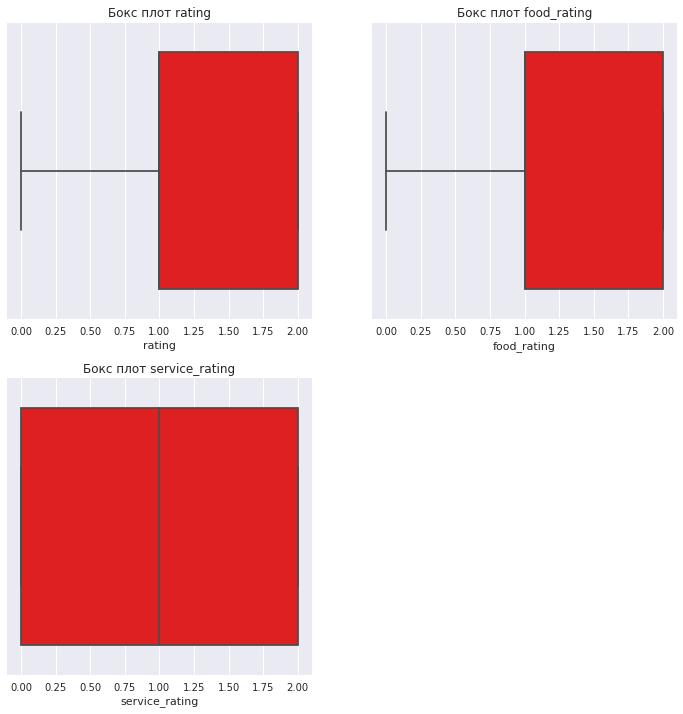

In [38]:
# Построим распределение рейтингов food_rating, service_rating с помощью блочной диаграммы

columns_to_plot = ['rating', 'food_rating', 'service_rating']

plt.figure(figsize=(12, 12))
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=data, x=col, color='red')
    plt.xlabel(col)
    plt.title("Бокс плот {}".format(col))    
plt.show()

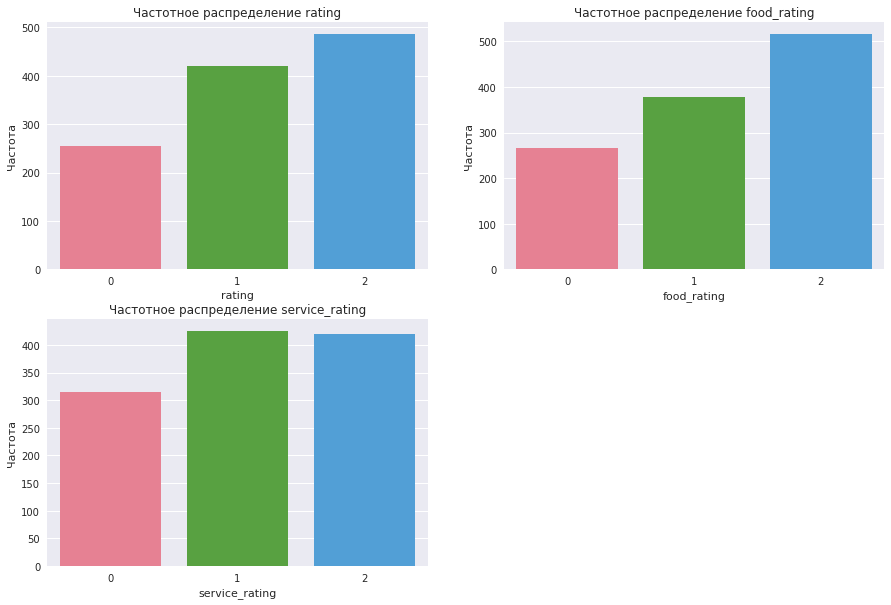

In [39]:
# Визуализируем распределение rating, food_rating и service_rating

columns_to_plot = ['rating', 'food_rating', 'service_rating']
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=data, x=col, palette='husl')
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.title("Частотное распределение {}".format(col))    
plt.show()

# Система рекомендаций

Для начала используем тип рекомендательной системы, который дает рекомендации на основе популярности продукта. Очень простой и понятный алгоритм

### Присваиваем баллы каждому ресторану на основе количества их посещений, т. е. место, которое встречается чаще всего, является более популярным, следовательно, получает высокий балл.

In [40]:
placeID_count = data.groupby('placeID').count()['userID'].to_dict()
data['placeScore'] = data['placeID'].map(placeID_count)

### Создаем 10 лучших рекомендаций

In [41]:
top_10_recommendations = pd.DataFrame(data['placeID'].value_counts()).reset_index().rename(columns = {'index' : 'placeID', 'placeID' : 'placeScore'}).iloc[ : 10]
top_10_recommendations = pd.merge(data[['placeID','name']], top_10_recommendations, on='placeID', how='right').drop_duplicates()

### 10 лучших рекомендаций

In [42]:
top_10_recommendations

,placeID,name,placeScore
0,135085,Tortas Locas Hipocampo,36
36,132825,puesto de tacos,32
68,135032,Cafeteria y Restaurant El Pacifico,28
96,135052,La Cantina Restaurante,25
121,132834,Gorditas Doa Gloria,25
146,135038,Restaurant la Chalita,24
170,135060,Restaurante Marisco Sam,22
192,135062,Restaurante El Cielo Potosino,21
213,135042,Restaurant Oriental Express,20
233,135058,Restaurante Tiberius,18


**2. Совместная фильтрация:**


В общем, совместная фильтрация — это процесс фильтрации информации с использованием методов, включающих несколько агентов, точку зрения, источники данных и т. д. В частности, для рекомендательных систем совместная фильтрация — это метод для создания прогнозов об интересах/предпочтениях пользователя в отношении продукта на основе интересы/предпочтения других подобных пользователей.

Основополагающее предположение, лежащее в основе этой концепции, состоит в том, что если человек А имеет такое же мнение о продукте, как и мнение человека Б о каком-то другом продукте, то весьма вероятно, что мнение А будет похоже на мнение Б о каком-то другом продукте, в отличии от случайно выбранного человека.

In [43]:
data.drop('placeScore', axis=1, inplace=True)

In [44]:
data.head()

,userID,placeID,name,rating,food_rating,service_rating
0,U1077,135085,Tortas Locas Hipocampo,2,2,2
1,U1108,135085,Tortas Locas Hipocampo,1,2,1
2,U1081,135085,Tortas Locas Hipocampo,1,2,1
3,U1056,135085,Tortas Locas Hipocampo,2,2,2
4,U1134,135085,Tortas Locas Hipocampo,2,1,2


### Создаем объект для чтения

In [45]:
reader = Reader(rating_scale=(0,2)) # Класс Reader используется для анализа файла, содержащего рейтинги.
rating_data = Dataset.load_from_df(data[['userID', 'placeID', 'rating']], reader)

# Использование разложения по сингулярным значениям (матричная факторизация) для построения рекомендательной системы

In [46]:
svd = SVD(verbose=True, n_epochs=100)
svd_results = cross_validate(svd, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [47]:
svd_results

{'test_rmse': array([0.65365934, 0.65104267, 0.68220918]),
 'test_mae': array([0.52987044, 0.53130267, 0.55458904]),
 'fit_time': (0.25042057037353516, 0.24772024154663086, 0.24522185325622559),
 'test_time': (0.0032835006713867188,
  0.0026786327362060547,
  0.002908945083618164)}

In [48]:
# Результаты SlopOne

slope_one = SlopeOne()
slope_one_results = cross_validate(slope_one, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7563  0.7775  0.7148  0.7495  0.0260  
MAE (testset)     0.5667  0.5745  0.5156  0.5522  0.0261  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    


In [49]:
slope_one_results

{'test_rmse': array([0.75634665, 0.77746053, 0.71478691]),
 'test_mae': array([0.56669483, 0.57445593, 0.51556528]),
 'fit_time': (0.0023374557495117188,
  0.0021839141845703125,
  0.0024318695068359375),
 'test_time': (0.004126310348510742,
  0.0032312870025634766,
  0.004116058349609375)}

In [50]:
# Совместная кластеризация
co_clustering = CoClustering(n_epochs=100, verbose=True, random_state=0)
co_clustering_results = cross_validate(co_clustering, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [51]:
co_clustering_results

{'test_rmse': array([0.72040653, 0.6975957 , 0.67635337]),
 'test_mae': array([0.53122943, 0.5184101 , 0.49201026]),
 'fit_time': (0.14549779891967773, 0.13156700134277344, 0.12971043586730957),
 'test_time': (0.0023391246795654297,
  0.0019884109497070312,
  0.0020797252655029297)}

### KNNBasic

In [52]:
knn_basic = KNNBasic(k=50)
knn_basic_results = cross_validate(knn_basic, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8384  0.8370  0.8384  0.8379  0.0007  
MAE (testset)     0.6888  0.6819  0.6664  0.6790  0.0093  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    


### KNNWithMeans

In [53]:
knn_means = KNNWithMeans(k=100)
knn_means_results = cross_validate(knn_means, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6904  0.6864  0.7138  0.6969  0.0121  
MAE (testset)     0.5159  0.4985  0.5348  0.5164  0.0148  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    


In [54]:
knn_means_results

{'test_rmse': array([0.69037119, 0.68643861, 0.71383111]),
 'test_mae': array([0.51591581, 0.49851358, 0.5347986 ]),
 'fit_time': (0.002763032913208008,
  0.0025720596313476562,
  0.002195119857788086),
 'test_time': (0.006704807281494141,
  0.006420135498046875,
  0.00616002082824707)}

### KNNWithZScore


In [55]:
knn_zscore = KNNWithZScore(k=100)
knn_zscore_results = cross_validate(knn_zscore, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6492  0.6879  0.7357  0.6909  0.0354  
MAE (testset)     0.4969  0.5028  0.5574  0.5190  0.0272  
Fit time          0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    


In [56]:
np.array((svd_results['test_rmse'], 
co_clustering_results['test_rmse'], 
slope_one_results['test_rmse'],
knn_basic_results['test_rmse'], 
knn_means_results['test_rmse'], 
knn_zscore_results['test_rmse']))

array([[0.65365934, 0.65104267, 0.68220918],
       [0.72040653, 0.6975957 , 0.67635337],
       [0.75634665, 0.77746053, 0.71478691],
       [0.83841881, 0.83700522, 0.83840753],
       [0.69037119, 0.68643861, 0.71383111],
       [0.64918674, 0.68789891, 0.73573764]])

# Объединим результаты всех моделей

In [57]:
results = np.array((svd_results['test_rmse'], 
                    co_clustering_results['test_rmse'], 
                    slope_one_results['test_rmse'],
                    knn_basic_results['test_rmse'], 
                    knn_means_results['test_rmse'], 
                    knn_zscore_results['test_rmse']))

result_df = pd.DataFrame(results, 
                         index=['SVD', 'CoClustering', 'SlopeOne', 'KNN_Basic', 'KNN_Means', 'KNN_ZScore'],
                         columns=['RMSE_fold_1','RMSE_fold_2','RMSE_fold_3'])

# Вычислим средний балл RMSE

In [58]:
result_df['Mean_RMSE'] = result_df[['RMSE_fold_1', 'RMSE_fold_2', 'RMSE_fold_3']].mean(axis=1)

In [59]:
result_df.sort_values(by='Mean_RMSE')

,RMSE_fold_1,RMSE_fold_2,RMSE_fold_3,Mean_RMSE
SVD,0.653659,0.651043,0.682209,0.662304
KNN_ZScore,0.649187,0.687899,0.735738,0.690941
KNN_Means,0.690371,0.686439,0.713831,0.696880
CoClustering,0.720407,0.697596,0.676353,0.698119
SlopeOne,0.756347,0.777461,0.714787,0.749531
KNN_Basic,0.838419,0.837005,0.838408,0.837944


**KNN_Basic работает лучше всех.**

# Создание рекомендаций с использованием KNN_Basic

In [62]:
# 1. Получить идентификатор ресторана из названия ресторана
def get_rest_id(rest_name, data):
    '''Возвращает идентификатор ресторана (placeID) с учетом названия ресторана.'''


    rest_names = list(data['name'].values)
    
    # Using difflib find the restaurants that are closest to the input and extract the corresponding placeID
    
    closest_names = difflib.get_close_matches(rest_name, rest_names)
    rest_id = data[data['name'] == closest_names[0]]['placeID'].iloc[0]
    
    return rest_id

# 2. Предсказать рейтинг этого ресторана для данного пользователя
def predict_rating(user_id, rest_name, data, model=KNNBasic(k=50)):
    
    # извлечь идентификатор ресторана из названия ресторана
    rest_id = get_rest_id(rest_name, data)
    
    # сделать предсказания
    estimated_ratings = model.predict(uid = user_id, iid = rest_id)
    
    return estimated_ratings.est

# 3. Генерация рекомендаций для данного пользователя

'''
При этом мы возьмем userID в качестве входных данных и выведем названия всех ресторанов, для которых данный пользователь, скорее всего,
дать рейтинг выше определенного порогового рейтинга (в данном случае 1,5).
'''


def recommend_restaurants(user_id, data=data, model=KNNBasic(k=50), threshold=1.5):
    
    # сохраним в словаре рекомендуемые рестораны вместе с прогнозируемыми рейтингами, данными пользователем 
    recommended_restaurants = {}
    
# Найдем все уникальные названия ресторанов    
    unique_rest_names = list(np.unique(data['name'].values))
    
# Перемешаем список названий ресторанов
    random.shuffle(unique_rest_names)
    
# перебираем список и генерируем рейтинги (прогнозы) для каждого ресторана и возвращаем только те, у которых рейтинг > порога (1,5)
    for rest_name in unique_rest_names:
        

        # сгенерируем прогнозы
        rating = predict_rating(user_id=user_id, rest_name=rest_name, data=data, model=KNNBasic(k=50))
        
# проверим, если рейтинг > порога
        if rating > threshold:
            
            recommended_restaurants[rest_name] = np.round(rating,2)
    
    print("Создание рекомендаций по ресторанам для идентификатора пользователя {} : ".format(user_id))    
    restaurant_names = np.array(list(recommended_restaurants.keys())).reshape(-1,1)
    restaurant_ratings = np.array(list(recommended_restaurants.values())).reshape(-1,1)
    
    results = np.concatenate((restaurant_names, restaurant_ratings), axis=1)
    results_df = pd.DataFrame(results, columns=['Restaurants', 'Rating (0-2)']).sort_values(by='Rating (0-2)', ascending=False)
    
    return results_df.reset_index().drop('index', axis=1)

In [63]:
# Случайным образом выбрать идентификатор пользователя, используя np.random.choice
random_user_id = np.random.choice(list(np.unique(data['userID'].values)))

# Создание рекомендаций для идентификатора пользователя
recommend_restaurants(user_id = random_user_id)

Создание рекомендаций по ресторанам для идентификатора пользователя U1002 : 


,Restaurants,Rating (0-2)
0,Luna Cafe,1.8
1,crudalia,1.79
2,puesto de tacos,1.79
3,Restaurant Las Mananitas,1.78
4,Michiko Restaurant Japones,1.77
5,Kiku Cuernavaca,1.75
6,Cabana Huasteca,1.72
7,Sirlone,1.7
8,Restaurante la Parroquia Potosina,1.7
9,KFC,1.67
